# Импорты

In [141]:
import numpy as np
from scipy.stats import norm
import networkx as nx
from collections import defaultdict
from matplotlib import pyplot as plt
import pandas as pd

# Импорт всех данных из варианта
from base.task_option import *

# Класс сетевого анализа

In [142]:
class NetworkPlanning:
    def __init__(self):
        self.works = {}
        self.dummy_list = []
        self.graph = nx.DiGraph()
        self.daily_cost = 0  # Стоимость одного дня проекта
        
    def add_link(self, linked_tasks, num_nodes):
        """
        Добавление связей между работами на основе структуры linked_tasks
        """
        # Используем атрибут класса, а не локальную переменную
        self.graph = nx.DiGraph()

        # Добавляем узлы
        for i in range(num_nodes):
            self.graph.add_node(i)

        # Создаем словарь для быстрого доступа к этапам работ
        task_stages = {name: stages for name, stages in linked_tasks}
        
        # Добавляем реальные работы
        for name, stages in linked_tasks:
            if name not in self.works:
                continue
                
            work = self.works[name]
            self.graph.add_edge(
                stages[0],  # Начало ребра
                stages[1],  # Конец ребра
                task=name,
                duration=work['t_pes'],
                real=True
            )

        # Создаем словарь для быстрого доступа к работам по имени
        task_dict = {name: self.works[name] for name in self.works if name in task_stages}

        # Добавляем фиктивные работы
        self.dummy_list = []
        
        for name, stages in linked_tasks:
            if name not in self.works:
                continue
                
            work = self.works[name]
            
            for dep_name in work['dependencies']:
                if dep_name == '-':
                    continue
                    
                if dep_name in task_stages:
                    dep_stages = task_stages[dep_name]
                    start = stages[0]  # Начало текущей задачи
                    dep_end = dep_stages[1]  # Окончание зависимости

                    # Проверяем необходимость фиктивной работы
                    if dep_end != start:
                        has_connection = False

                        # Проверяем все входящие ребра в начальный этап текущей задачи
                        for u, v, d in self.graph.in_edges(start, data=True):
                            if v == start and u == dep_end:
                                has_connection = True
                                break

                        # Добавляем фиктивное ребро при отсутствии соединения
                        if not has_connection:
                            self.dummy_list.append((dep_end, start))
                            dummy_label = f"dummy_{dep_end}_{start}"
                            self.graph.add_edge(
                                dep_end, 
                                start, 
                                task=dummy_label,
                                duration=0, 
                                real=False
                            )
    
    def get_graph(self):
        """Возвращает граф проекта"""
        return self.graph
    
    def get_dummy_list(self):
        """Возвращает список фиктивных работ"""
        return self.dummy_list.copy()

    def add_work(self, name, dependencies, t_pes, t_ver, t_opt, cost_reduction):
        """Добавление работы с её характеристиками"""
        self.works[name] = {
            'dependencies': dependencies,
            't_pes': t_pes,      # Максимальная продолжительность
            't_ver': t_ver,      # Вероятностная оценка (может не использоваться)
            't_opt': t_opt,      # Минимальная продолжительность
            'cost_reduction': cost_reduction,  # Стоимость сокращения на 1 день
            'current_duration': t_pes  # Текущая продолжительность (начинается с максимальной)
        }
    
    def set_daily_cost(self, daily_cost):
        """Установка стоимости одного дня проекта"""
        self.daily_cost = daily_cost
    
    def calculate_initial_cost(self):
        """Расчет начальной стоимости проекта (при максимальных продолжительностях)"""
        critical_path = self.find_critical_path_max_duration()
        if not critical_path:
            return None
        
        duration = critical_path['critical_time']
        return duration * self.daily_cost
    
    def find_critical_path_max_duration(self):
        """Нахождение критического пути при максимальных продолжительностях"""
        return self._find_critical_path('t_pes')
    
    def find_critical_path_current_duration(self):
        """Нахождение критического пути при текущих продолжительностях"""
        return self._find_critical_path('current_duration')
    
    def _find_critical_path(self, duration_type):
        """Общий метод нахождения критического пути"""
        try:
            # Создаем временный граф с заданными продолжительностями
            temp_graph = nx.DiGraph()
            
            # Добавляем ребра с соответствующими продолжительностями
            for u, v, data in self.graph.edges(data=True):
                if data.get('real', False):
                    work_name = data['task']
                    if work_name in self.works:
                        duration = self.works[work_name][duration_type]
                        temp_graph.add_edge(u, v, weight=duration, name=work_name)
                else:
                    temp_graph.add_edge(u, v, weight=0, name=data['task'])
            
            # Находим критический путь
            if not nx.is_directed_acyclic_graph(temp_graph):
                return None
            
            longest_path_nodes = nx.dag_longest_path(temp_graph, weight='weight')
            critical_time = nx.dag_longest_path_length(temp_graph, weight='weight')
            
            # Находим работы на критическом пути
            critical_works = []
            for i in range(len(longest_path_nodes) - 1):
                if temp_graph.has_edge(longest_path_nodes[i], longest_path_nodes[i+1]):
                    edge_data = temp_graph[longest_path_nodes[i]][longest_path_nodes[i+1]]
                    if 'name' in edge_data:
                        critical_works.append(edge_data['name'])
            
            return {
                'critical_time': critical_time,
                'critical_works': critical_works,
                'critical_nodes': longest_path_nodes
            }
        except (nx.NetworkXError, KeyError):
            return None
    
    def optimize_cost_minimal_duration(self):
        """
        Основной метод оптимизации стоимости при минимально возможном сроке
        Реализует логику из поставленной задачи
        """
        # Шаг 1: Начальная стоимость при максимальных продолжительностях
        initial_critical_path = self.find_critical_path_max_duration()
        if not initial_critical_path:
            return None
        
        T_initial = initial_critical_path['critical_time']
        S_initial = T_initial * self.daily_cost
        
        # Шаг 2: Поиск работ для сокращения на критическом пути
        reduction_plan = self._find_optimal_reductions()
        
        # Шаг 3: Расчет оптимальной стоимости
        optimal_result = self._calculate_optimal_cost(reduction_plan)
        
        # Дополнительная информация
        work_stats = self.get_work_statistics()
        minimal_possible_duration = self.calculate_minimal_possible_duration()
        
        return {
            'initial_duration': T_initial,
            'initial_cost': S_initial,
            'optimal_duration': optimal_result['duration'],
            'optimal_cost': optimal_result['cost'],
            'reduction_plan': reduction_plan,
            'works_duration_changes': optimal_result['duration_changes'],
            'work_statistics': work_stats,
            'minimal_possible_duration': minimal_possible_duration,
            'total_savings': S_initial - optimal_result['cost'],
            'reduction_cost': optimal_result['cost'] - (optimal_result['duration'] * self.daily_cost)
        }
    
    def _calculate_optimal_cost(self, reduction_plan):
        """
        Расчет оптимальной стоимости на основе плана сокращений
        """
        # Восстанавливаем максимальные продолжительности
        for work in self.works.values():
            work['current_duration'] = work['t_pes']
        
        total_reduction_cost = 0
        duration_changes = {}
        
        # Применяем план сокращений и рассчитываем стоимость
        for step in reduction_plan:
            # Обработка нового формата (словарь works)
            if 'works' in step:
                for work_name, reduction_days in step['works'].items():
                    work = self.works[work_name]
                    cost = work['cost_reduction'] * reduction_days
                    
                    # Применяем сокращение
                    work['current_duration'] -= reduction_days
                    total_reduction_cost += cost
                    
                    # Запоминаем изменения
                    if work_name not in duration_changes:
                        duration_changes[work_name] = 0
                    duration_changes[work_name] += reduction_days
            else:
                # Старый формат (для обратной совместимости)
                work_name = step['work']
                reduction_days = step['days']
                cost = step['cost']
                
                self.works[work_name]['current_duration'] -= reduction_days
                total_reduction_cost += cost
                
                if work_name not in duration_changes:
                    duration_changes[work_name] = 0
                duration_changes[work_name] += reduction_days
        
        # Текущая продолжительность после всех сокращений
        current_critical_path = self.find_critical_path_current_duration()
        optimal_duration = current_critical_path['critical_time']
        
        # Общая стоимость = стоимость дней + стоимость сокращений
        optimal_cost = (optimal_duration * self.daily_cost) + total_reduction_cost
        
        return {
            'duration': optimal_duration,
            'cost': optimal_cost,
            'duration_changes': duration_changes
        }
    
    def calculate_minimal_possible_duration(self):
        """Расчет минимально возможной продолжительности проекта"""
        # Создаем граф с минимальными продолжительностями
        temp_graph = nx.DiGraph()
        
        for u, v, data in self.graph.edges(data=True):
            if data.get('real', False):
                work_name = data['task']
                if work_name in self.works:
                    duration = self.works[work_name]['t_opt']  # Минимальная продолжительность
                    temp_graph.add_edge(u, v, weight=duration, name=work_name)
            else:
                temp_graph.add_edge(u, v, weight=0, name=data['task'])
        
        try:
            return nx.dag_longest_path_length(temp_graph, weight='weight')
        except nx.NetworkXError:
            return None
    
    def get_work_statistics(self):
        """Статистика по всем работам"""
        stats = {}
        for name, work in self.works.items():
            stats[name] = {
                'max_duration': work['t_pes'],
                'min_duration': work['t_opt'],
                'current_duration': work['current_duration'],
                'possible_reduction': work['t_pes'] - work['t_opt'],
                'cost_per_day': work['cost_reduction'],
                'delta_cost': self.daily_cost - work['cost_reduction']  # Δk = S - sk
            }
        return stats
    
    def _find_optimal_reductions(self):
        """
        Поиск оптимальной последовательности сокращений работ
        С учетом параллельных критических путей
        """
        reduction_steps = []
        
        # Восстанавливаем максимальные продолжительности
        for work in self.works.values():
            work['current_duration'] = work['t_pes']
        
        iteration = 0
        max_iterations = 50
        
        while iteration < max_iterations:
            iteration += 1
            
            # Находим ВСЕ критические пути
            critical_paths = self._find_all_critical_paths()
            if not critical_paths:
                break
                
            # Находим лучший вариант сокращения
            best_reduction = self._find_best_reduction_option(critical_paths)
            
            # ОСТАНАВЛИВАЕМСЯ, если сокращение невыгодно (Δk <= 0)
            if not best_reduction or best_reduction['days'] <= 0 or best_reduction['delta_cost'] <= 0:
                break
                
            # Применяем сокращение
            for work_name, reduction_days in best_reduction['works'].items():
                self.works[work_name]['current_duration'] -= reduction_days
            
            reduction_steps.append(best_reduction)
        
        return reduction_steps

    def _find_all_critical_paths(self):
        """Нахождение всех критических путей"""
        current_critical = self.find_critical_path_current_duration()
        if not current_critical:
            return []
        
        T_kr = current_critical['critical_time']
        all_paths = self._get_all_paths()
        
        critical_paths = []
        for path_data in all_paths.values():
            if abs(path_data['duration'] - T_kr) < 0.001:  # Учитываем погрешность
                critical_paths.append(path_data)
        
        return critical_paths

    def _find_multi_path_reduction(self, critical_paths):
        """Сокращение для нескольких критических путей"""
        print(f"  Поиск группового сокращения для {len(critical_paths)} критических путей")
        
        # Находим работы, которые присутствуют на нескольких путях
        work_count = {}
        all_works = set()
        
        for path in critical_paths:
            path_works = set(path['works'])
            all_works.update(path_works)
            for work in path_works:
                work_count[work] = work_count.get(work, 0) + 1
        
        print(f"  Работы на критических путях: {all_works}")
        print(f"  Количество путей по работам: {work_count}")
        
        # Сначала пробуем найти одну работу, которая покрывает все пути
        for work_name in all_works:
            if work_count[work_name] == len(critical_paths):
                work = self.works[work_name]
                if work['current_duration'] > work['t_opt']:
                    delta = self.daily_cost - work['cost_reduction']
                    if delta > 0:
                        print(f"  Найдена работа {work_name}, покрывающая все пути (Δk={delta})")
                        possible_reduction = work['current_duration'] - work['t_opt']
                        return {
                            'type': 'multi',
                            'works': {work_name: possible_reduction},
                            'days': possible_reduction,
                            'delta_cost': delta,
                            'total_savings': delta * possible_reduction
                        }
                    if delta <= 0:
                        print("  Групповое сокращение невыгодно")
                        return None
        
        # Если нет одной работы, покрывающей все пути, ищем комбинацию
        # Для простоты возьмем по одной самой дешевой работе с каждого пути
        reduction_candidates = {}
        
        for path in critical_paths:
            cheapest_work = None
            min_cost = float('inf')
            
            for work_name in path['works']:
                work = self.works[work_name]
                
                # Проверяем возможность сокращения
                if work['current_duration'] <= work['t_opt']:
                    continue
                    
                # Проверяем выгодность (Δk > 0)
                delta = self.daily_cost - work['cost_reduction']
                if delta <= 0:
                    continue
                    
                if work['cost_reduction'] < min_cost:
                    cheapest_work = work_name
                    min_cost = work['cost_reduction']
            
            if cheapest_work and cheapest_work not in reduction_candidates:
                reduction_candidates[cheapest_work] = min_cost
        
        print(f"  Кандидаты для группового сокращения: {reduction_candidates}")
        
        if not reduction_candidates:
            print("  Нет подходящих кандидатов")
            return None
        
        # Вычисляем суммарную стоимость и экономию
        total_reduction_cost = sum(reduction_candidates.values())
        delta = self.daily_cost - total_reduction_cost
        
        print(f"  Суммарная стоимость сокращения: {total_reduction_cost}")
        print(f"  Δk группового сокращения: {delta}")
        
        # Находим минимальное возможное сокращение среди кандидатов
        max_days = float('inf')
        reduction_plan = {}
        
        for work_name in reduction_candidates.keys():
            work = self.works[work_name]
            possible_reduction = work['current_duration'] - work['t_opt']
            max_days = min(max_days, possible_reduction)
            reduction_plan[work_name] = max_days
            print(f"  {work_name}: можно сократить на {possible_reduction} дней")
        
        if max_days <= 0:
            print("  Невозможно сократить выбранные работы")
            return None
        
        print(f"  Групповое сокращение возможно на {max_days} дней")
        return {
            'type': 'multi',
            'works': reduction_plan,
            'days': max_days,
            'delta_cost': delta,
            'total_savings': delta * max_days
        }

    def _find_best_reduction_option(self, critical_paths):
        """Поиск лучшего варианта сокращения среди всех критических путей"""
        if len(critical_paths) == 1:
            # Один критический путь - сокращаем одну работу
            return self._find_single_path_reduction(critical_paths[0])
        else:
            # Несколько критических путей - сокращаем группы работ
            return self._find_multi_path_reduction(critical_paths)

    def _get_all_paths(self):
        """Получение всех путей в графе с расчетом продолжительности"""
        all_paths = {}
        start_nodes = [node for node in self.graph.nodes() if self.graph.in_degree(node) == 0]
        end_nodes = [node for node in self.graph.nodes() if self.graph.out_degree(node) == 0]
        
        for start in start_nodes:
            for end in end_nodes:
                try:
                    paths = list(nx.all_simple_paths(self.graph, start, end))
                    for path in paths:
                        duration = 0
                        path_works = []
                        
                        for i in range(len(path) - 1):
                            edge_data = self.graph[path[i]][path[i+1]]
                            if edge_data.get('real', False):
                                work_name = edge_data['task']
                                if work_name in self.works:
                                    duration += self.works[work_name]['current_duration']
                                    path_works.append(work_name)
                            else:
                                # Фиктивные работы не добавляют времени
                                path_works.append(edge_data['task'])
                        
                        path_key = ' -> '.join(map(str, path))
                        all_paths[path_key] = {
                            'duration': duration,
                            'works': path_works,
                            'nodes': path
                        }
                except:
                    continue
        
        return all_paths
    
    def get_non_critical_reserves(self):
        """Расчет резервов некритических путей"""
        critical_path = self.find_critical_path_current_duration()
        if not critical_path:
            return {}
        
        T_kr = critical_path['critical_time']
        all_paths = self._get_all_paths()
        
        reserves = {}
        for path_key, path_data in all_paths.items():
            reserve = T_kr - path_data['duration']
            if reserve > 0:  # Только некритические пути
                reserves[path_key] = {
                    'duration': path_data['duration'],
                    'works': path_data['works'],
                    'reserve': reserve
                }
        
        return reserves
    
    def _find_single_path_reduction(self, critical_path):
        """Сокращение для одного критического пути"""
        best_work = None
        best_delta = -float('inf')
        max_days = 0
        
        for work_name in critical_path['works']:
            work = self.works[work_name]
            
            # Проверяем возможность сокращения
            current_duration = work['current_duration']
            min_duration = work['t_opt']
            
            if current_duration <= min_duration:
                continue
                
            # Вычисляем экономию
            delta = self.daily_cost - work['cost_reduction']
            
            # Пропускаем невыгодные сокращения (Δk <= 0)
            if delta <= 0:
                continue
                
            # Находим максимальное возможное сокращение
            possible_reduction = current_duration - min_duration
            
            # Учитываем резервы только ПАРАЛЛЕЛЬНЫХ некритических путей
            # которые могут стать критическими при сокращении
            reserves = self.get_non_critical_reserves()
            
            # Находим резерв пути, который станет критическим при сокращении этой работы
            relevant_reserve = possible_reduction  # по умолчанию - максимальное возможное
            
            for path_data in reserves.values():
                if work_name in path_data['works']:
                    # Этот путь содержит сокращаемую работу
                    relevant_reserve = min(relevant_reserve, path_data['reserve'])
            
            allowed_reduction = min(possible_reduction, relevant_reserve)
            
            if delta > best_delta and allowed_reduction > 0:
                best_work = work_name
                best_delta = delta
                max_days = allowed_reduction
        
        if best_work and best_delta > 0:
            return {
                'type': 'single',
                'work': best_work,
                'works': {best_work: max_days},
                'days': max_days,
                'cost': self.works[best_work]['cost_reduction'] * max_days,
                'delta_cost': best_delta,
                'total_savings': best_delta * max_days
            }
        
        return None

# Создаем граф связи задач

In [143]:
# Создаем экземпляр класса
np_solver = NetworkPlanning()

for work in works_data:
    np_solver.add_work(*work)

linked_tasks = [
    ('b1', (0, 1)),
    ('b2', (0, 3)),
    ('b3', (1, 6)),
    ('b4', (1, 2)),
    ('b5', (2, 5)),
    ('b6', (3, 5)),
    ('b7', (3, 4)),
    ('b8', (4, 5)),
    ('b9', (5, 6)),
    ('b10', (6, 7)),
    ('b11', (5, 7))
]

# Добавляем связи
num_nodes = 8
np_solver.add_link(linked_tasks, num_nodes)

# Получаем граф и список фиктивных работ
G = np_solver.get_graph()
DUMMY_TASKS = np_solver.get_dummy_list()

print("Граф создан с", G.number_of_nodes(), "узлами и", G.number_of_edges(), "ребрами")
print("Фиктивные работы:", DUMMY_TASKS)

Граф создан с 8 узлами и 12 ребрами
Фиктивные работы: [(2, 6)]


# Основные расчеты

In [144]:
# Устанавливаем стоимость одного дня проекта
np_solver.set_daily_cost(S_k)

# 1. Начальные параметры проекта
print("1. НАЧАЛЬНЫЕ ПАРАМЕТРЫ ПРОЕКТА:")
initial_cost = np_solver.calculate_initial_cost()
critical_path_max = np_solver.find_critical_path_max_duration()
print(f"   Критический путь при максимальных продолжительностях: {critical_path_max['critical_time']} дней")
print(f"   Работы на критическом пути: {', '.join(critical_path_max['critical_works'])}")
print(f"   Начальная стоимость проекта: {initial_cost} ден. ед.\n")

# 2. Минимально возможная продолжительность
print("2. МИНИМАЛЬНО ВОЗМОЖНАЯ ПРОДОЛЖИТЕЛЬНОСТЬ:")
min_duration = np_solver.calculate_minimal_possible_duration()
print(f"   Минимально возможный срок выполнения: {min_duration} дней\n")

# 3. Оптимизация стоимости
print("3. ОПТИМИЗАЦИЯ СТОИМОСТИ ПРОЕКТА:")
optimal_result = np_solver.optimize_cost_minimal_duration()

if optimal_result:
    print(f"   Начальная продолжительность: {optimal_result['initial_duration']} дней")
    print(f"   Начальная стоимость: {optimal_result['initial_cost']} ден. ед.")
    print(f"   Оптимальная продолжительность: {optimal_result['optimal_duration']} дней")
    print(f"   Оптимальная стоимость: {optimal_result['optimal_cost']} ден. ед.")
    print(f"   Экономия: {optimal_result['total_savings']} ден. ед.")
    print(f"   Стоимость сокращения работ: {optimal_result['reduction_cost']} ден. ед.\n")

# 4. Статистика по работам
print("4. СТАТИСТИКА ПО РАБОТАМ:")
work_stats = np_solver.get_work_statistics()
for work_name, stats in work_stats.items():
    print(f"   {work_name}: макс={stats['max_duration']}, мин={stats['min_duration']}, тек={stats['current_duration']}, "
          f"Δk={stats['delta_cost']}")

# 5. План сокращений
print("\n5. ПЛАН СОКРАЩЕНИЙ РАБОТ:")
reduction_plan = optimal_result['reduction_plan']
for i, step in enumerate(reduction_plan, 1):
    if step['type'] == 'single':
        work_name = list(step['works'].keys())[0]
        days = step['works'][work_name]
        print(f"   Шаг {i}: Сокращение работы {work_name} на {days} дней")
        print(f"       Экономия: {step['total_savings']} ден. ед.")
    else:
        works_str = ", ".join([f"{w}({d}дн)" for w, d in step['works'].items()])
        print(f"   Шаг {i}: Групповое сокращение: {works_str}")
        print(f"       Экономия: {step['total_savings']} ден. ед.")

# 6. Изменения продолжительностей работ
print("\n6. ИЗМЕНЕНИЯ ПРОДОЛЖИТЕЛЬНОСТЕЙ РАБОТ:")
duration_changes = optimal_result['works_duration_changes']
for work_name, change in duration_changes.items():
    if change > 0:
        original = np_solver.works[work_name]['t_pes']
        current = np_solver.works[work_name]['current_duration']
        print(f"   {work_name}: {original} → {current} дней (сокращение на {change} дней)")

# 7. Критический путь после оптимизации
print("\n7. КРИТИЧЕСКИЙ ПУТЬ ПОСЛЕ ОПТИМИЗАЦИИ:")
current_critical = np_solver.find_critical_path_current_duration()
if current_critical:
    print(f"   Продолжительность: {current_critical['critical_time']} дней")
    print(f"   Работы на критическом пути: {', '.join(current_critical['critical_works'])}")

# 8. Резервы некритических путей
print("\n8. РЕЗЕРВЫ НЕКРИТИЧЕСКИХ ПУТЕЙ:")
reserves = np_solver.get_non_critical_reserves()
for path, data in list(reserves.items())[:5]:  # Показываем первые 5 путей
    print(f"   Путь: {path}")
    print(f"   Резерв: {data['reserve']} дней")

print(f"\nВсего некритических путей: {len(reserves)}")

# 9. Сравнение с директивным сроком
print(f"\n9. СРАВНЕНИЕ С ДИРЕКТИВНЫМ СРОКОМ ({T_dir} дней):")
if optimal_result:
    optimal_duration = optimal_result['optimal_duration']
    if optimal_duration <= T_dir:
        print(f"    Проект может быть выполнен за {optimal_duration} дней (укладывается в директивный срок)")
    else:
        print(f"    Проект требует {optimal_duration} дней (превышает директивный срок на {optimal_duration - T_dir} дней)")

1. НАЧАЛЬНЫЕ ПАРАМЕТРЫ ПРОЕКТА:
   Критический путь при максимальных продолжительностях: 38 дней
   Работы на критическом пути: b2, b7, b8, b9, b10
   Начальная стоимость проекта: 380 ден. ед.

2. МИНИМАЛЬНО ВОЗМОЖНАЯ ПРОДОЛЖИТЕЛЬНОСТЬ:
   Минимально возможный срок выполнения: 12 дней

3. ОПТИМИЗАЦИЯ СТОИМОСТИ ПРОЕКТА:
  Поиск группового сокращения для 2 критических путей
  Работы на критических путях: {'b8', 'b10', 'b1', 'b2', 'b9', 'b7', 'b3'}
  Количество путей по работам: {'b1': 1, 'b3': 1, 'b10': 2, 'b8': 1, 'b2': 1, 'b9': 1, 'b7': 1}
  Найдена работа b10, покрывающая все пути (Δk=2)
  Поиск группового сокращения для 3 критических путей
  Работы на критических путях: {'b8', 'b10', 'b1', 'b2', 'b9', 'b7', 'b11', 'b3'}
  Количество путей по работам: {'b1': 1, 'b3': 1, 'b10': 2, 'b8': 2, 'b2': 2, 'b9': 1, 'b7': 2, 'b11': 1}
  Кандидаты для группового сокращения: {'b1': 4, 'b2': 8, 'b11': 7}
  Суммарная стоимость сокращения: 19
  Δk группового сокращения: -9
  b1: можно сократить на 5

# Утилиты расчетов

In [145]:
def calculate_early_times(graph):
    # Топологическая сортировка узлов
    topo_order = list(nx.topological_sort(graph))

    # Инициализация словаря для хранения Tр
    early_times = {node: 0 for node in graph.nodes}

    # Проход по узлам в топологическом порядке
    for node in topo_order:
        # Все входящие ребра для текущего узла
        predecessors = list(graph.predecessors(node))

        # Если есть предшественники
        if predecessors:
            # Вычисляем максимальное значение (Tр предшественника + длительность работы)
            max_time = max(
                early_times[p] + graph.edges[p, node]['duration']
                for p in predecessors
            )
            early_times[node] = max_time

    return early_times

In [146]:
def calculate_late_times_correct(graph, early_times):
    # Инициализация словаря для хранения Tп
    late_times = {node: 0 for node in graph.nodes}

    # Установка Tп для завершающего узла равным его раннему сроку
    end_node = max(graph.nodes)
    late_times[end_node] = early_times[end_node]

    # Топологическая сортировка узлов в обратном порядке
    topo_order = list(reversed(list(nx.topological_sort(graph))))

    # Проход по узлам в обратном топологическом порядке
    for node in topo_order:
        # Пропускаем завершающий узел, он уже обработан
        if node == end_node:
            continue

        # Все исходящие ребра для текущего узла
        successors = list(graph.successors(node))

        # Если есть последующие узлы, вычисляем минимальное значение
        if successors:
            min_time = min(
                late_times[s] - graph.edges[node, s]['duration']
                for s in successors
            )
            late_times[node] = min_time
        # Если нет последующих узлов (кроме завершающего), присваиваем Tп завершающего узла
        else:
            late_times[node] = late_times[end_node]

    return late_times

In [147]:
def find_critical_path_alt(critical_works):
    critical_path_edges = list(critical_works)
    
    # Проверяем, что критический путь существует
    if not critical_path_edges:
        return []

    # Создаем список узлов, входящих в критический путь
    critical_path_nodes = set()
    for edge in critical_path_edges:
        critical_path_nodes.add(edge[0])
        critical_path_nodes.add(edge[1])
    
    # Начинаем с начального узла (0) и ищем следующий узел в критическом пути
    start_node = 0
    ordered_path = [start_node]
    
    while True:
        next_node = None
        for u, v in critical_path_edges:
            if u == start_node and v not in ordered_path:
                next_node = v
                break
        
        if next_node is None:
            break  # Достигли конца критического пути

        ordered_path.append(next_node)
        start_node = next_node

    return ordered_path

In [148]:
# Получаем ранние и поздние сроки
early_times = calculate_early_times(G)
late_times  = calculate_late_times_correct(G, early_times)

# Расчет резервов времени для каждого события
reserves = {node: late_times[node] - early_times[node] for node in G.nodes}

# Определим критические работы (полный резерв = 0)
critical_works = {
    (u, v) for u, v in G.edges()
    if late_times[v] - early_times[u] - G.edges[u, v]['duration'] == 0 
    and G.edges[u, v].get('real', True)  # Используем get() для безопасного доступа
}

# Находим критический путь (самый длинный путь)
critical_path = find_critical_path_alt(critical_works)

# Преобразуем путь в список ребер
critical_edges = []
for i in range(len(critical_path)-1):
    critical_edges.append((critical_path[i], critical_path[i+1]))

# Расчет параметров для всех работ (реальных и фиктивных)
all_work_params = {}

# Проходим по всем работам в графе (и реальным, и фиктивным)
for u, v, data in G.edges(data=True):
    task = data.get('task', f"edge_{u}_{v}")  # Используем get() для безопасного доступа
    
    # 1. Наиболее поздний допустимый срок окончания работы (E_n)
    E_n = late_times[v]  # T_n(j)
    
    # 2. Наиболее ранний возможный срок начала работы (S_p)
    S_p = early_times[u]  # T_p(i)
    
    # 3. Полный резерв времени работы (r_n)
    duration = data['duration']
    full_reserve = late_times[v] - early_times[u] - duration
    
    # 4. Независимый резерв времени работы (r_n_ind)
    independent_reserve = max(0, early_times[v] - late_times[u] - duration)
    
    all_work_params[task] = {
        'S_p': S_p,
        'E_n': E_n,
        'Полный резерв': full_reserve,
        'Независимый резерв': independent_reserve,
        'Тип': 'Реальная' if data.get('real', True) else 'Фиктивная',  # Используем get()
        'Продолжительность работы': duration 
    }

# Создаем правильный порядок вывода
order = ['b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 'b8', 'b9', 'b10', 'b11'] + \
        [t for t in all_work_params if t.startswith('dummy')]

# 1. Найдём критический путь (используем NetworkX)
critical_path = nx.dag_longest_path(G, weight='duration')
critical_nodes = set(critical_path)

# 2. Определим критические работы (полный резерв = 0)
critical_works = {
    (u, v) for u, v in G.edges() 
    if late_times[v] - early_times[u] - G.edges[u,v]['duration'] == 0
}

# 3. Найдём все возможные пути между критическими событиями
valid_chains = []
for source in critical_nodes:
    for target in critical_nodes:
        if source == target:  # Исключаем петли
            continue
            
        try:
            for path in nx.all_simple_paths(G, source, target):
                # Проверяем, что путь не содержит критических работ
                path_edges = list(zip(path[:-1], path[1:]))
                if not any(edge in critical_works for edge in path_edges):
                    valid_chains.append(path)
        except nx.NetworkXNoPath:
            continue

# 4. Расчёт параметров (с проверкой порядка узлов в критическом пути)
results = []
for chain in valid_chains:
    start, end = chain[0], chain[-1]
    
    try:
        # Ищем индексы в критическом пути
        start_idx = critical_path.index(start)
        end_idx = critical_path.index(end)
        
        # Проверяем правильный порядок
        if start_idx >= end_idx:
            continue
            
        # Вычисляем длину критического подпути
        crit_subpath = critical_path[start_idx:end_idx+1]
        a = sum(G.edges[u,v]['duration'] 
               for u,v in zip(crit_subpath, crit_subpath[1:]) 
               if G.edges[u,v].get('real', True)) # учитываем только реальные работы
        
        # Длина некритического пути
        b = sum(G.edges[u,v]['duration'] 
               for u,v in zip(chain, chain[1:]) 
               if G.edges[u,v].get('real', True))
        
        # Расчет параметров
        R = a - b
        N = round(b / a, 3) if a > 0 else 0
        
        # Формируем запись
        chain_name = f"({chain[0]},{chain[-1]})"
        works = "+".join(G.edges[u,v].get('task', f"edge_{u}_{v}") 
                        for u,v in zip(chain, chain[1:]) 
                        if G.edges[u,v].get('real', True))
        
        results.append({
            'Дуга': chain_name,
            'a': a,
            'b': b,
            'R(b)': R,
            'N(b)': N,
            'Работы': works
        })
        
    except (ValueError, IndexError):
        continue

# 1. Таблица ранних сроков
early_data = []
for node in sorted(early_times):
    paths = []
    for predecessor in G.predecessors(node):
        duration = G.edges[predecessor, node]['duration']
        paths.append(f"{predecessor} - {node} ({duration} дн.) = {early_times[predecessor]} + {duration}")
    
    early_data.append({
        'Этап': node,
        'Tр': early_times[node],
        'Пути достижения': "\n".join(paths) if paths else "Начальное"
    })
early_df = pd.DataFrame(early_data)

# 2. Таблица поздних сроков
late_data = []
for node in sorted(late_times, reverse=True):
    successors = list(G.successors(node))
    if successors:
        calc = "\n".join([f"Tп({s}) - t{node}{s} = {late_times[s]} - {G.edges[node, s]['duration']}" 
                         for s in successors])
        calculation = f"min:\n{calc}"
    else:
        calculation = f"Tп({node}) = Tкр\n= {late_times[node]}"
    
    late_data.append({
        'Этап': node,
        'Tп': late_times[node],
        'Расчет': calculation
    })
late_df = pd.DataFrame(late_data)

# 3. Таблица резервов времени
reserves_df = pd.DataFrame({
    'Этап': sorted(reserves.keys()),
    'R(i)': [reserves[node] for node in sorted(reserves)],
    'Расчет': [f"{late_times[node]} - {early_times[node]}" for node in sorted(reserves)]
})

# 4. Сводная таблица
summary_df = pd.DataFrame({
    'Этап': sorted(G.nodes),
    'Tр': [early_times[node] for node in sorted(G.nodes)],
    'Tп': [late_times[node] for node in sorted(G.nodes)],
    'R(i)': [reserves[node] for node in sorted(G.nodes)]
})

# 5. Таблица параметров работ
works_data = []
for task in ['b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 'b8', 'b9', 'b10', 'b11'] + \
             [t for t in all_work_params if t.startswith('dummy')]:
    if task in all_work_params:
        params = all_work_params[task]
        works_data.append({
            'Работа': task,
            'Тип работы': params['Тип'][:10],
            'Продолжительность': params['Продолжительность работы'], 
            'Нач. (S_p)': params['S_p'],
            'Кон. (E_n)': params['E_n'],
            'Полн. рез.': params['Полный резерв'],
            'Незав. рез.': params['Независимый резерв']
        })
works_df = pd.DataFrame(works_data)

# 6. Обработка некритических дуг (только если results существует)
if results:
    chains_df = pd.DataFrame(results)
    if not chains_df.empty:
        chains_df['Работы'] = chains_df['Работы']
        chains_df['Дуга'] = chains_df['Дуга'].str.replace(',', ' - ')
else:
    chains_df = pd.DataFrame()  # Создаем пустой DataFrame

In [149]:
def calculate_positions(graph, DUMMY_TASKS):
    # Определяем слои для каждого узла
    layers = {}
    for node in nx.topological_sort(graph):
        if graph.in_degree(node) == 0:
            layers[node] = 0
        else:
            layers[node] = max(layers[pred] for pred in graph.predecessors(node)) + 1
    
    # Группируем узлы по слоям
    layer_groups = defaultdict(list)
    for node, layer in layers.items():
        layer_groups[layer].append(node)
    
    # Рассчитываем координаты
    pos = {}
    for layer, nodes in layer_groups.items():
        nodes_sorted = sorted(nodes)
        num_nodes = len(nodes_sorted)
        for idx, node in enumerate(nodes_sorted):
            y = idx / max(1, num_nodes - 1)  # Нормализация Y от 0 до 1
            pos[node] = (layer * 2, y)       # Умножаем X для увеличения расстояния
    
    
    count_of_dummies = len(DUMMY_TASKS)
    if count_of_dummies != 0:

        level_threshold = 0.5

        # Смещаем все элементы на половину от графика
        for node in pos:
            x, y = pos[node]

            if y <= level_threshold:  
                pos[node] = (x, y + level_threshold)

        offset = level_threshold / count_of_dummies
        
        local_offset_low  = 0
        local_offset_high = 0

        for dummy in DUMMY_TASKS:
            
            dep_end = dummy[1]

            dep_end_y = pos[dep_end][1] # Значение по оси y для конечной точки
            if dep_end_y <= 0.5: 

                # Элемент снизу
                local_offset_low += offset
            
                pos[dep_end] = (
                    pos[dep_end][0], 
                    dep_end_y - local_offset_low
                )
            else:

                # Элемент сверху
                local_offset_high += offset

                pos[dep_end] = (
                    pos[dep_end][0], 
                    dep_end_y - local_offset_high
                )

    return pos

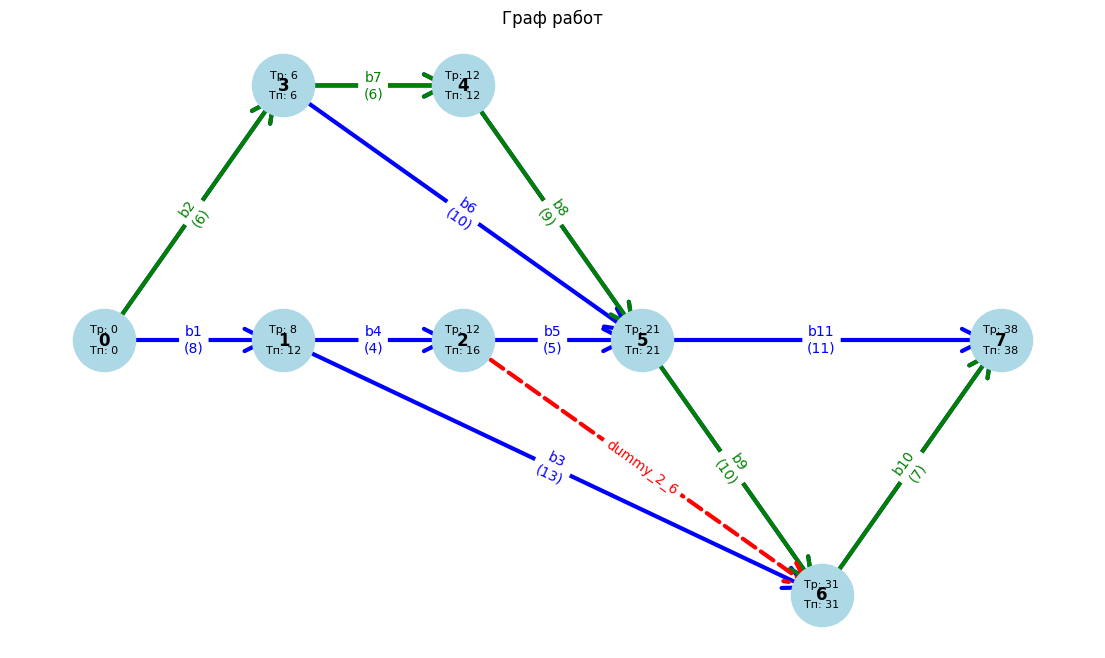

In [150]:
# Используем автоматические позиции
pos = calculate_positions(G, DUMMY_TASKS)

plt.figure(figsize=(14, 8))

# Разделяем реальные и фиктивные работы
real_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('real', True)]
dummy_edges = [(u, v) for u, v, d in G.edges(data=True) if not d.get('real', True)]

# Выделяем критические работы
critical_real_edges = [edge for edge in real_edges if edge in critical_edges]

# Рисуем узлы
nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='lightblue')
nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')

# Рисуем реальные работы (синие сплошные)
nx.draw_networkx_edges(G, pos, edgelist=real_edges, edge_color='blue',
                      width=3, arrowstyle='->', arrowsize=40)

# Рисуем критические работы (зеленые сплошные, толще)
nx.draw_networkx_edges(G, pos, edgelist=critical_real_edges, edge_color='green',
                      width=3, arrowstyle='->', arrowsize=40)

# Рисуем фиктивные работы (красные пунктирные)
nx.draw_networkx_edges(G, pos, edgelist=dummy_edges, edge_color='red',
                      width=3, style='dashed', arrowstyle='->', arrowsize=40)

# Подписи для реальных работ
real_labels = {(u, v): f"{d.get('task', f'edge_{u}_{v}')}\n({d['duration']})" for u, v, d in G.edges(data=True) if d.get('real', True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=real_labels, font_color='blue')

# Подписи для критических работ (зеленые)
critical_labels = {(u, v): f"{G.edges[u, v].get('task', f'edge_{u}_{v}')}\n({G.edges[u, v]['duration']})" for u, v in critical_real_edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels=critical_labels, font_color='green')

# Подписи для фиктивных работ
dummy_labels = {(u, v): d.get('task', f'edge_{u}_{v}') for u, v, d in G.edges(data=True) if not d.get('real', True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=dummy_labels, font_color='red')

# Добавление меток для ранних и поздних сроков
early_labels = {node: f"Tр: {early_times[node]}" for node in G.nodes}
late_labels = {node: f"Tп: {late_times[node]}" for node in G.nodes}

# Позиции для меток
early_pos = {node: (x, y + 0.02) for node, (x, y) in pos.items()}
late_pos = {node: (x, y - 0.02) for node, (x, y) in pos.items()}

# Рисуем метки для ранних сроков
nx.draw_networkx_labels(G, early_pos, labels=early_labels, font_size=8)

# Рисуем метки для поздних сроков
nx.draw_networkx_labels(G, late_pos, labels=late_labels, font_size=8)
plt.title("Граф работ")
plt.axis('off')
plt.show()